In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path

import sys, pickle, torch
sys.path.append('../')
from utils import *
from torchani.units import HARTREE_TO_KCALMOL

In [2]:
title_size = 22
smaller_size = 18
tick_size = 14

In [4]:
data = np.load('m522583_1-2_OptOnly.npz')
#data = np.load('m6403_0-4_OptOnly.npz')
numbers, coord = data['numbers'], data['coord']

SlidableAtomic3D(numbers, coord)

interactive(children=(IntSlider(value=0, description='Index', max=13), Output()), _dom_classes=('widget-intera…

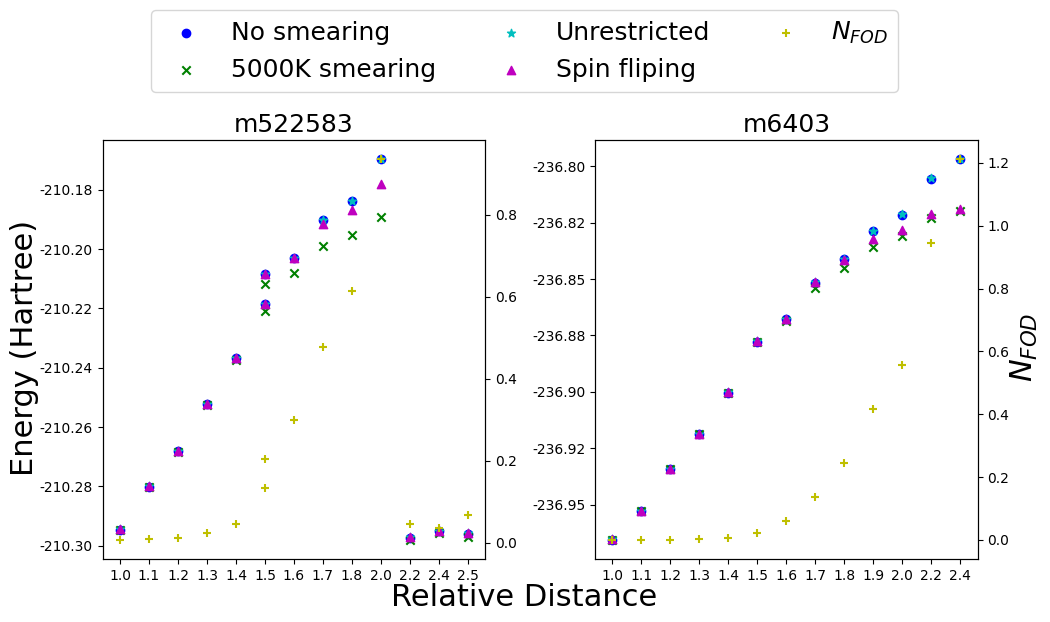

In [3]:
to_compare = [
    'm522583_1-2_OptOnly.npz',
    'm6403_0-4_OptOnly.npz']

mol_names = ['m522583', 'm6403',]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, file, name, atom_indices in zip(axs.flat, to_compare, mol_names, ((1, 2), (0, 4))):
    data = np.load(file)
    a1_coords = data['coord'][:, atom_indices[0], :]
    a2_coords = data['coord'][:, atom_indices[1], :]
    distances = np.linalg.norm(a1_coords - a2_coords, axis=1)
    distances = distances/distances[0]
    #idx_to_plot = np.arange(len(data['numbers']))+1
    idx_to_plot = ["%.1f"%(d) for d in distances]
    ax.scatter(idx_to_plot, data['b973c.energy'], label='No smearing', marker = 'o', color = 'b')
    ax.scatter(idx_to_plot, data['b973c_etemp5000.energy'], label='5000K smearing', marker = 'x', color = 'g')
    ax.scatter(idx_to_plot, data['b973c_unrestricted.energy'], label='Unrestricted', marker = '*', color = 'c')
    ax.scatter(idx_to_plot, data['b973c_flipspin.energy'], label='Spin fliping', marker = '^', color = 'm')
    ax.set_title(name, fontsize=smaller_size)
    ax.set_xticks(idx_to_plot)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    ax2 = ax.twinx()
    ax2.scatter(idx_to_plot, data['b973c_etemp5000.fod'], label=r'$N_{FOD}$', marker = '+', color = 'y')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

fig.text(0.5, 0.0, 'Relative Distance', ha='center', va='center', fontsize=title_size)
fig.text(0.0, 0.5, 'Energy (Hartree)', ha='center', va='center', rotation='vertical', fontsize=title_size)
fig.text(1.0, 0.5, r'$N_{FOD}$', ha='center', va='center', rotation='vertical', fontsize=title_size)
#fig.legend(['No smearing', '5000K smearing', 'Unrestricted', 'Spin fliping', 'FOD'], loc='upper center', 
#           bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=smaller_size)
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fontsize=smaller_size)
plt.tight_layout()

plt.show()

In [2]:
MODEL_TO_TEST = [
    '../trained_models/init_ani1xT5000hartree_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '../trained_models/init_ani1x_bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '../trained_models/init_ani1x_ani1xT5000+bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
]

MODEL_NAMES = [
    'ANI-1x trained',
    'ANI-1xBB trained',
    'merge trained',
]

loaded_models = []
device = 'cuda:1'

for m in MODEL_TO_TEST:
    model = torch.load(m)
    model.requires_grad_(False)
    model.periodic_table_index = True
    model = model.to(device)
    loaded_models.append(model)

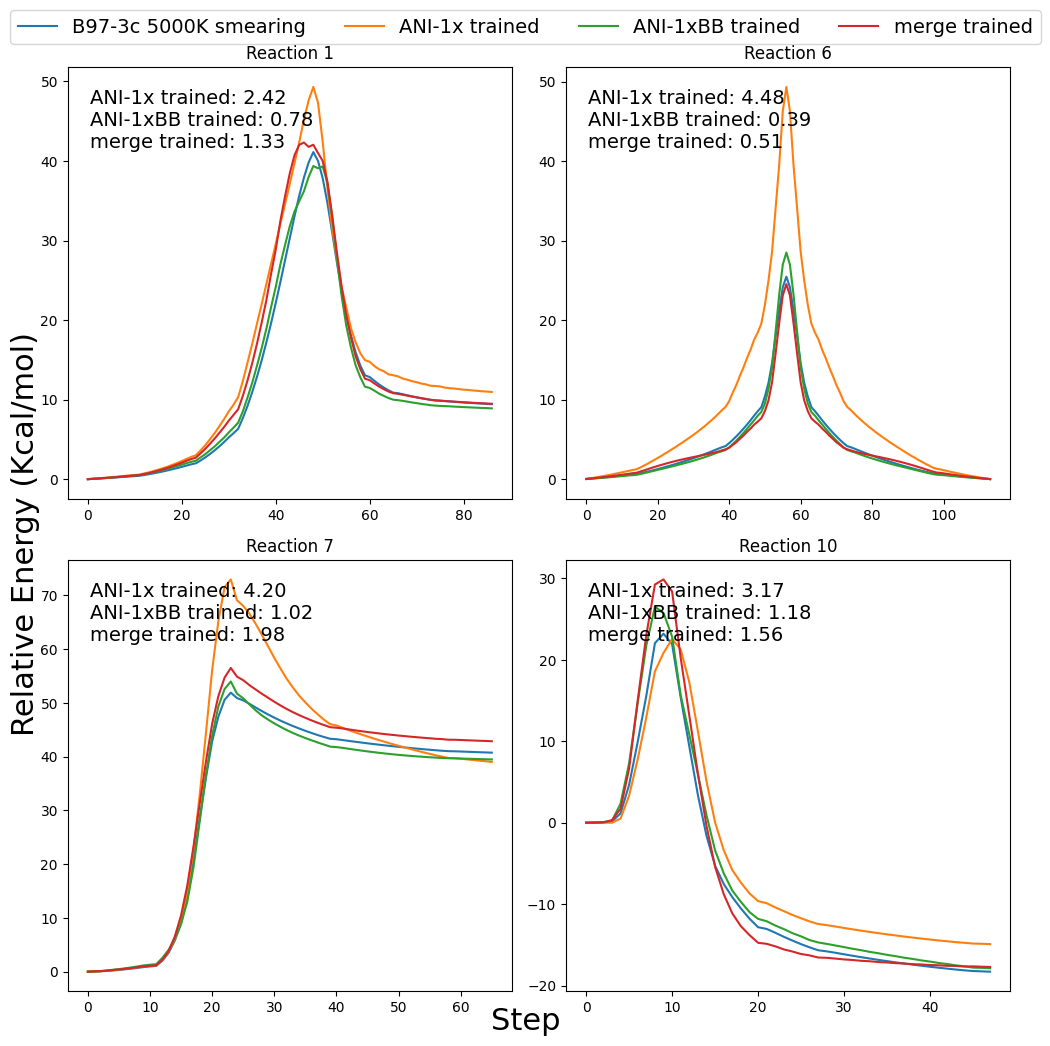

In [5]:
selected_reactions = [1, 6, 7, 10]

#create a figure with 2*2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

all_ref = []
all_pred = {k: [] for k in MODEL_NAMES}

for i, reaction_idx in enumerate(selected_reactions):
    data = np.load('PericyclicReactions/IRC%d_IRC_Full_trj.npz'%(reaction_idx))
    N = len(data['numbers'])
    indices = list(range(N))
    to_plot = {}
    for model, name in zip(loaded_models, MODEL_NAMES):
        pred = model((torch.tensor(data['numbers']).to(device).long(), torch.tensor(data['coord']).to(device).float())).energies
        pred = (pred - pred[0]) * HARTREE_TO_KCALMOL
        to_plot[name] = pred.detach().cpu().numpy()

    ref = (data['b973c_etemp5000.energy'] - data['b973c_etemp5000.energy'][0]) * HARTREE_TO_KCALMOL
    all_ref.append(ref)
    ax = axs[i//2, i%2]
    ax.plot(indices, ref, label='b973c_etemp5000.energy')
    note = ''
    for k in to_plot:
        diff = np.abs(to_plot[k] - ref)
        mae = np.mean(diff)
        rmse = np.sqrt(np.mean(diff**2))
        note += '%s: %.2f\n'%(k, mae)
        ax.plot(indices, to_plot[k], label=k)

        all_pred[k].append(to_plot[k])
    ax.set_title('Reaction %d'%(reaction_idx))
    
    #write down the note at the top-left corner
    ax.text(0.05, 0.95, note, transform=ax.transAxes, fontsize=tick_size, verticalalignment='top')

#set public labels to the figure
fig.text(0.5, 0.0, 'Step', ha='center', fontsize=title_size)
fig.text(0.0, 0.3, 'Relative Energy (Kcal/mol)', ha='center', rotation='vertical', fontsize=title_size)
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.tight_layout()
fig.legend(['B97-3c 5000K smearing']+MODEL_NAMES, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=4, fontsize=tick_size)
plt.show()

In [17]:
data = np.load('PericyclicReactions/IRC10_IRC_Full_trj.npz')
numbers, coord = data['numbers'], data['coord']

SlidableAtomic3D(numbers, coord)

interactive(children=(IntSlider(value=0, description='Index', max=47), Output()), _dom_classes=('widget-intera…